In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np # USE NUMPY VERSION 1.26.1
#import math
#import pickle
#import torch
import dill
import random


# Load Dataset

In [2]:
# dataset is split to several parts due to it's size
df_products = pd.read_csv(f"amazon_products_part_0.csv")
for i in [1, 2, 3, 4]:
    curr_part = pd.read_csv(f"amazon_products_part_{i}.csv")
    df_products = pd.concat([df_products, curr_part])

In [3]:
df_categories = pd.read_csv("amazon_categories.csv")

In [4]:
len(df_products)

1426337

In [5]:
df_products.head(10)

,Unnamed: 0,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000
1,1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000
2,2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300
3,3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400
4,4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400
5,5,B07XSCD2R4,Maxlite 5 Softside Expandable Luggage with 4 S...,https://m.media-amazon.com/images/I/61LnBNsSBS...,https://www.amazon.com/dp/B07XSCD2R4,4.5,0,144.49,0.00,104,False,500
6,6,B07MXF4G8K,"Hard Shell Carry on Luggage Airline Approved, ...",https://m.media-amazon.com/images/I/71CghLYrnA...,https://www.amazon.com/dp/B07MXF4G8K,4.5,0,169.99,0.00,104,False,400
7,7,B07H515VCZ,"Maxporter II 30"" Hardside Spinner Trunk Luggag...",https://m.media-amazon.com/images/I/81f3h+YHOX...,https://www.amazon.com/dp/B07H515VCZ,4.5,0,299.99,0.00,104,False,100
8,8,B08BXBCNMQ,Omni 2 Hardside Expandable Luggage with Spinne...,https://m.media-amazon.com/images/I/91eOWP4myS...,https://www.amazon.com/dp/B08BXBCNMQ,4.5,0,112.63,137.04,104,False,500
9,9,B0B9K44XTS,Luggage Sets Expandable Lightweight Suitcases ...,https://m.media-amazon.com/images/I/81dsv5GrCL...,https://www.amazon.com/dp/B0B9K44XTS,4.4,0,209.99,0.00,104,False,200


In [6]:
# total of 248 categories
df_categories.head(10)

,id,category_name
0,1,Beading & Jewelry Making
1,2,Fabric Decorating
2,3,Knitting & Crochet Supplies
3,4,Printmaking Supplies
4,5,Scrapbooking & Stamping Supplies
5,6,Sewing Products
6,7,Craft & Hobby Fabric
7,8,Needlework Supplies
8,9,"Arts, Crafts & Sewing Storage"
9,10,"Painting, Drawing & Art Supplies"


In [7]:
# ensuring there arent any duplicate categories
print(f"Duplicate Values: {len(df_categories) - len(df_categories['category_name'].unique())}")

Duplicate Values: 0


In [8]:
# joining category name to each product based on category id
df_categories.rename(columns={"id":"category_id"},inplace=True)
df_products = pd.merge(df_products,df_categories,how='left',on='category_id')

In [9]:
# ensuring that each prodcut recieved a category name
df_products[df_products['category_name'].isna()]

,Unnamed: 0,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name


In [10]:
# result example
df_products.sample(frac=1) #frac=0.001

,Unnamed: 0,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
254033,254033,B0CF179GYB,Smut Gift Call Me A Good Girl Tote Bag Smut Re...,https://m.media-amazon.com/images/I/81Afqf0mkV...,https://www.amazon.com/dp/B0CF179GYB,0.0,0,15.89,0.00,118,False,0,Women's Handbags
945354,945354,B0041EDKWQ,Red Line Oil 75W90 Gear Oil- Pack of 4 Quarts,https://m.media-amazon.com/images/I/61jCVD9US5...,https://www.amazon.com/dp/B0041EDKWQ,4.7,0,75.99,0.00,20,False,50,Oils & Fluids
617140,617140,B0C3CW1558,"Small Tower Fan For Bedroom Desk, 10000mAh Rec...",https://m.media-amazon.com/images/I/81qDxDO8kZ...,https://www.amazon.com/dp/B0C3CW1558,4.5,0,17.99,0.00,171,False,50,"Heating, Cooling & Air Quality"
1348794,1348794,B09VNRWZZ6,Cuisinart C55CB-11PM Advantage Cutlery 11-Piec...,https://m.media-amazon.com/images/I/712PZQPPYb...,https://www.amazon.com/dp/B09VNRWZZ6,4.8,0,16.80,17.88,156,False,400,Food Service Equipment & Supplies
1358187,1358187,B00BHNX0YC,SSI Technologies - MG1-1000-A-9V-R SSI TECHNOL...,https://m.media-amazon.com/images/I/6177GpuJmx...,https://www.amazon.com/dp/B00BHNX0YC,4.7,0,127.99,0.00,145,False,0,"Test, Measure & Inspect"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366215,366215,B09B18SW3Y,"Philips One by Sonicare, 2 Brush Heads, Shadow...",https://m.media-amazon.com/images/I/61Gen8werp...,https://www.amazon.com/dp/B09B18SW3Y,4.7,0,9.96,0.00,135,False,7000,Health & Household
496850,496850,B0B82PYQZR,Pallet Banding Strapping Kit - Tensioner Seale...,https://m.media-amazon.com/images/I/71CqY+zWQz...,https://www.amazon.com/dp/B0B82PYQZR,4.8,0,78.99,0.00,160,False,0,Packaging & Shipping Supplies
771325,771325,B06WGZB2N4,DSD TECH HM-10 Bluetooth 4.0 BLE iBeacon UART ...,https://m.media-amazon.com/images/I/51biIjpkwk...,https://www.amazon.com/dp/B06WGZB2N4,4.4,0,10.99,0.00,63,False,0,Computer Components
94338,94338,B0968X6B5R,Mickey Mouse & Friends Boys' 4 Pack T-Shirt fo...,https://m.media-amazon.com/images/I/711-CuJVDn...,https://www.amazon.com/dp/B0968X6B5R,4.7,326,29.99,0.00,84,False,50,Boys' Clothing


# Statistics

In [11]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426337 entries, 0 to 1426336
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1426337 non-null  int64  
 1   asin               1426337 non-null  object 
 2   title              1426336 non-null  object 
 3   imgUrl             1426337 non-null  object 
 4   productURL         1426337 non-null  object 
 5   stars              1426337 non-null  float64
 6   reviews            1426337 non-null  int64  
 7   price              1426337 non-null  float64
 8   listPrice          1426337 non-null  float64
 9   category_id        1426337 non-null  int64  
 10  isBestSeller       1426337 non-null  bool   
 11  boughtInLastMonth  1426337 non-null  int64  
 12  category_name      1426337 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 131.9+ MB


<Axes: xlabel='category_name'>

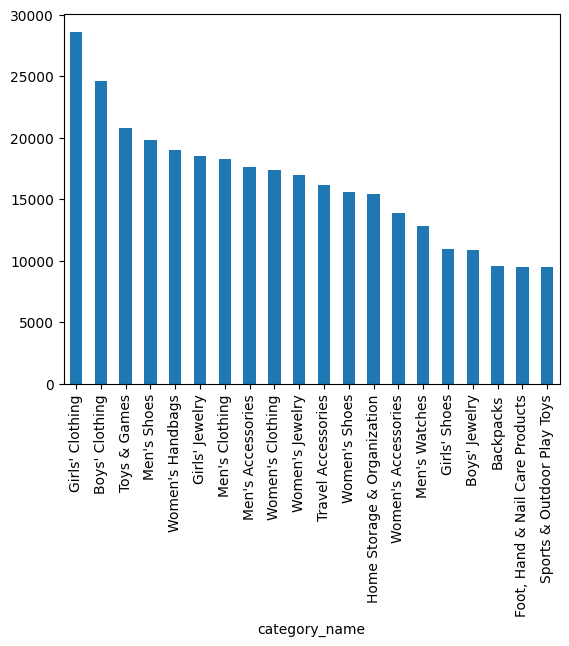

In [12]:
# get top n categories based on prodcuts amount
top_n_categories = 20
df_products['category_name'].value_counts().iloc[0:top_n_categories].plot.bar()

<Axes: xlabel='stars'>

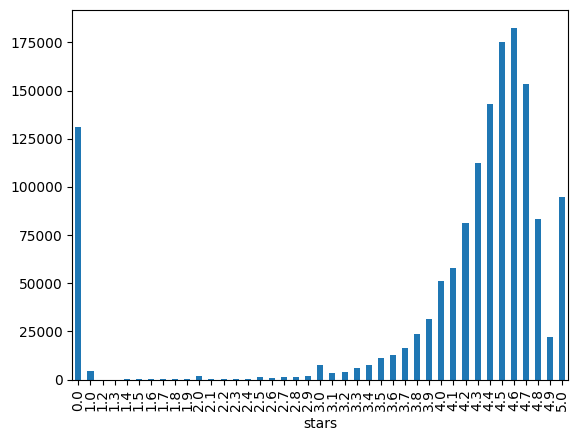

In [13]:
# stars distribution in the dataset
# note - 0 means never rated, also no product with 1.1 stars
df_products['stars'].value_counts().sort_index().plot.bar()

# Products Embedding With SentenceTransformers

In [14]:
# load sentence transformer model
sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\Dor24\OneDrive\Desktop\ML Recommendation Model\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
df_products['products_description'] = df_products['category_name'] + ': ' + df_products['title']

In [20]:
# attempt embedding a small selection to see if sentence transformer model works
embeddings_try = np.array([]).reshape(0, 384)
batch = sentence_transformer.encode(df_products['products_description'].tolist()[0:1000], show_progress_bar=True)
embeddings_try = np.concatenate([embeddings_try, batch])
print(embeddings_try)
print(np.shape(embeddings_try))


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

[[-0.03512515  0.04686889 -0.06903172 ... -0.03555478 -0.04063175
   0.03969698]
 [-0.06974322  0.03287227 -0.04866898 ... -0.02225349 -0.04279649
   0.00275383]
 [-0.02185156 -0.00110777 -0.04762367 ... -0.0168823  -0.04179648
  -0.00481995]
 ...
 [-0.05259237  0.08532655  0.01176212 ... -0.10208723 -0.10061102
   0.0134741 ]
 [ 0.03852349  0.08753097 -0.0615297  ... -0.13191515 -0.03316756
   0.02389139]
 [-0.00833438  0.12190781  0.06879773 ... -0.10455234 -0.036468
   0.03180588]]
(1000, 384)


In [22]:

# DO NOT RUN THIS CELL UNLESS THE FILE "embeddings.pkl" DOESN'T EXIST IN THE DIRECTORY

## convert products descriptions to embeddings
embeddings = np.array([]).reshape(0, 384) # initialize embeddings with empty array of vectors of size 384
for i in range((len(df_products['products_description']) // 100000) + 1): # split df_products to parts of size 100000
    lower = i * 100000
    upper = (i + 1) * 100000
    new_part = sentence_transformer.encode(df_products['products_description'].tolist()[lower:upper], show_progress_bar=False)
    embeddings = np.concatenate([embeddings, new_part]) # concatenate embeddings with new part
    print(f'Progress: {np.shape(embeddings)[0]}/{len(df_products['products_description'])}')

# pickle (dill) the embeddings
with open('embeddings.pkl', 'wb') as f:
    dill.dump(embeddings, f)
    print("Successfully pickled embeddings.")

# Load the embeddings with;
#  with open('embeddings.pkl', 'rb') as f:
#      embeddings = dill.load(f)


Progress: 100000/1426337
Progress: 200000/1426337
Progress: 300000/1426337
Progress: 400000/1426337
Progress: 500000/1426337
Progress: 600000/1426337
Progress: 700000/1426337
Progress: 800000/1426337
Progress: 900000/1426337
Progress: 1000000/1426337
Progress: 1100000/1426337
Progress: 1200000/1426337
Progress: 1300000/1426337
Progress: 1400000/1426337
Progress: 1426337/1426337
Successfully pickled embeddings.


In [16]:
try:
    with open('embeddings.pkl', 'rb') as f:
        embeddings = dill.load(f)
        print(embeddings.shape)
except FileNotFoundError:
    print("embeddings.pkl not found.")
else:
    f.close()

(1426337, 384)


In [17]:
## split data to train/test randomly
# shuffle indices of embeddings (not embeddings itself)
indices = np.arange(embeddings.shape[0])
np.random.shuffle(indices)

# split indices
split_point = 1400000
indices_train = indices[:split_point]
indices_test = indices[split_point:]

# get random data by indices
train_data = df_products.iloc[indices_train]
test_data = df_products.iloc[indices_test]
train_data_embeddings = embeddings[indices_train]
test_data_embeddings = embeddings[indices_test]

#train_data = embeddings.sample(n=1400000) # old code (frac=0.001)
print(np.__version__)
print(train_data.shape)
print(test_data.shape)

1.26.1
(1400000, 14)
(26337, 14)


In [28]:
# embeddings = sentence_transformer.encode(list(train_data['products_description']))

In [18]:
train_data.info()
print("========================================================")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400000 entries, 1199633 to 4858
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1400000 non-null  int64  
 1   asin                  1400000 non-null  object 
 2   title                 1399999 non-null  object 
 3   imgUrl                1400000 non-null  object 
 4   productURL            1400000 non-null  object 
 5   stars                 1400000 non-null  float64
 6   reviews               1400000 non-null  int64  
 7   price                 1400000 non-null  float64
 8   listPrice             1400000 non-null  float64
 9   category_id           1400000 non-null  int64  
 10  isBestSeller          1400000 non-null  bool   
 11  boughtInLastMonth     1400000 non-null  int64  
 12  category_name         1400000 non-null  object 
 13  products_description  1399999 non-null  object 
dtypes: bool(1), float64(3), int64(4), ob

In [19]:
train_data_numerical_features = train_data[['stars','price','listPrice','isBestSeller','boughtInLastMonth','reviews']].copy()
train_data_numerical_features['isBestSeller'].replace({True:'1',False:'0'},inplace=True)

C:\Users\Dor24\AppData\Local\Temp\ipykernel_18188\3415102979.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data_numerical_features['isBestSeller'].replace({True:'1',False:'0'},inplace=True)


In [20]:
combined_features = np.hstack((train_data_embeddings, train_data_numerical_features))

In [21]:
combined_features.shape

(1400000, 390)

# Train An Unsupervised K-Clusters Model

In [26]:
# Apply K-means clustering
num_clusters = 150 # more centers - higher accuracy but more time it takes to fit data
state = random.randint(1, 1000) # state of the machine, usually random
kmeans = KMeans(n_clusters=num_clusters, random_state=state)
kmeans.fit(train_data_embeddings)
print(kmeans.cluster_centers_.shape)

(150, 384)


# Inference

In [27]:
new_product_description = "25% Discount off Pizza-Hut Order!"
# embeddings are of type np.float64, sometimes the precision returned is np.float32
new_product_embedding = sentence_transformer.encode(new_product_description).reshape(1, -1).astype(np.float64)

In [28]:
# get predicted cluster
predicted_cluster = kmeans.predict(new_product_embedding)[0]
cluster_indices = np.where(kmeans.labels_ == predicted_cluster)[0]

# Retrieve similar products from the same cluster
similar_products = [train_data.iloc[i] for i in cluster_indices]

In [29]:
pd.DataFrame(similar_products)

,Unnamed: 0,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name,products_description
1018751,1018751,B0B8SYDBSN,"Ninja ST100 Foodi 2-in-1 Flip Toaster, 2-Slice...",https://m.media-amazon.com/images/I/71gqvIfjiq...,https://www.amazon.com/dp/B0B8SYDBSN,4.6,0,79.99,94.90,170,False,900,Kitchen & Dining,Kitchen & Dining: Ninja ST100 Foodi 2-in-1 Fli...
1353607,1353607,B08NJX7M9R,Chef Knife Ultra Sharp Kitchen Knife Set 3 PCS...,https://m.media-amazon.com/images/I/71kjdDJOqH...,https://www.amazon.com/dp/B08NJX7M9R,4.6,0,39.99,0.00,156,False,200,Food Service Equipment & Supplies,Food Service Equipment & Supplies: Chef Knife ...
1349622,1349622,B07K3MDGHY,"Ello Jane Ceramic Travel Mug with Handle, Spla...",https://m.media-amazon.com/images/I/61b4ZO0r8K...,https://www.amazon.com/dp/B07K3MDGHY,4.3,0,14.99,0.00,156,False,500,Food Service Equipment & Supplies,Food Service Equipment & Supplies: Ello Jane C...
1349381,1349381,B0BHQ93WGZ,"35 PCS 3.5""x 2.4""x 1.38""Clear Rice Krispie Tre...",https://m.media-amazon.com/images/I/71NBrg0gLa...,https://www.amazon.com/dp/B0BHQ93WGZ,4.6,0,9.90,0.00,156,False,500,Food Service Equipment & Supplies,"Food Service Equipment & Supplies: 35 PCS 3.5""..."
1019494,1019494,B014KG4YZ6,"Kicking Horse Coffee, Smart Ass, Medium Roast,...",https://m.media-amazon.com/images/I/61xKQrSf2d...,https://www.amazon.com/dp/B014KG4YZ6,4.4,0,8.99,9.49,170,False,1000,Kitchen & Dining,"Kitchen & Dining: Kicking Horse Coffee, Smart ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018816,1018816,B01FKO5JLU,"TAZO Tea Bags, Earl Grey, High Caffeine and Bo...",https://m.media-amazon.com/images/I/81-rDa4Ma1...,https://www.amazon.com/dp/B01FKO5JLU,4.8,0,23.34,0.00,170,False,1000,Kitchen & Dining,"Kitchen & Dining: TAZO Tea Bags, Earl Grey, Hi..."
697415,697415,B075ZTLB7H,SOLO Cup Company Clear Recycled Plastic Party ...,https://m.media-amazon.com/images/I/71uoPCJXVX...,https://www.amazon.com/dp/B075ZTLB7H,4.8,0,33.27,0.00,130,False,600,Household Supplies,Household Supplies: SOLO Cup Company Clear Rec...
1353656,1353656,B09XRDFKS4,Retirement Gifts For Women - Stainless Steel T...,https://m.media-amazon.com/images/I/81+8NnuV-F...,https://www.amazon.com/dp/B09XRDFKS4,4.9,0,24.95,0.00,156,False,100,Food Service Equipment & Supplies,Food Service Equipment & Supplies: Retirement ...
906770,906770,B07GHJFRRB,"Bayco 8 Pack Glass Food Storage Containers, Gl...",https://m.media-amazon.com/images/I/71U9ZVRWy9...,https://www.amazon.com/dp/B07GHJFRRB,4.7,0,39.99,49.99,173,False,1000,Home Storage & Organization,Home Storage & Organization: Bayco 8 Pack Glas...


In [30]:
with open('kmeans150.pkl', 'wb') as f:
    dill.dump(kmeans, f)
    print("Successfully pickled embeddings.")

Successfully pickled embeddings.


In [31]:
# To load a model:
try:
    with open('kmeans150.pkl', 'rb') as f:
        kmeans = dill.load(f)
except FileNotFoundError:
    print("File not found.")
else:
    f.close()